# Financial News Sentiment Analysis Project
## Part 2: Data Cleaning & Feature Engineering

This notebook performs:
1. Deep text cleaning operations
2. Feature engineering (TF-IDF, Word2Vec)
3. Dataset splitting and balancing

## 1. Import Libraries & Load Data

In [30]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Configure project paths
current_dir = Path.cwd()
if (current_dir / 'src').exists():
    project_root = current_dir
elif (current_dir.parent / 'src').exists():
    project_root = current_dir.parent
else:
    project_root = Path('c:/Users/xuzijian/Desktop/新闻情感/project')

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from preprocessor import TextPreprocessor, SentimentNormalizer

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [31]:
# Load cleaned data
parent_dir = project_root.parent
if os.path.exists(str(project_root / 'data' / 'processed' / 'merged_cleaned.csv')):
    data_path = str(project_root / 'data' / 'processed' / 'merged_cleaned.csv')
else:
    data_path = str(parent_dir / 'data' / 'processed' / 'merged_cleaned.csv')

df = pd.read_csv(data_path)
print(f"✓ Loaded {len(df)} samples")
print(f"Columns: {list(df.columns)}")

✓ Loaded 29507 samples
Columns: ['text', 'sentiment', 'source', 'language', 'sentiment_normalized', 'text_length', 'word_count']


## 2. Text Preprocessing

In [32]:
# Preprocess by language
en_mask = df['language'] == 'English'
zh_mask = df['language'] == 'Chinese'

# English preprocessing
if en_mask.sum() > 0:
    preprocessor_en = TextPreprocessor('english')
    df.loc[en_mask, 'text_cleaned'] = df.loc[en_mask, 'text'].apply(
        lambda x: preprocessor_en.preprocess(x, remove_urls=True, remove_emails=True,
                                              remove_html=True, remove_special=True,
                                              remove_punct=True, remove_stops=True,
                                              lemmatize=True, tokenize=False)
        if pd.notna(x) else ''
    )

# Chinese preprocessing
if zh_mask.sum() > 0:
    preprocessor_zh = TextPreprocessor('chinese')
    df.loc[zh_mask, 'text_cleaned'] = df.loc[zh_mask, 'text'].apply(
        lambda x: preprocessor_zh.preprocess(x, remove_urls=True, remove_emails=True,
                                              remove_html=True, remove_special=True,
                                              remove_punct=True, remove_stops=True,
                                              lemmatize=False, tokenize=False)
        if pd.notna(x) else ''
    )

print(f"✓ Preprocessing completed: EN={en_mask.sum()}, ZH={zh_mask.sum()}")

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1000)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1000)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1000)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1000)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1000)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF o

✓ Preprocessing completed: EN=12081, ZH=17426


In [33]:
# Filter short texts (< 3 words)
df['cleaned_length'] = df['text_cleaned'].apply(lambda x: len(str(x).split()))

before_filter = len(df)
df = df[df['cleaned_length'] >= 3]
after_filter = len(df)

print(f"✓ Removed short texts: {before_filter} → {after_filter} (removed {before_filter - after_filter})")

✓ Removed short texts: 29507 → 29375 (removed 132)


## 3. Handle Class Imbalance

Sentiment distribution:
sentiment_normalized
positive    11653
neutral     10964
negative     6758
Name: count, dtype: int64

Percentage:
sentiment_normalized
positive    39.7
neutral     37.3
negative    23.0
Name: count, dtype: float64


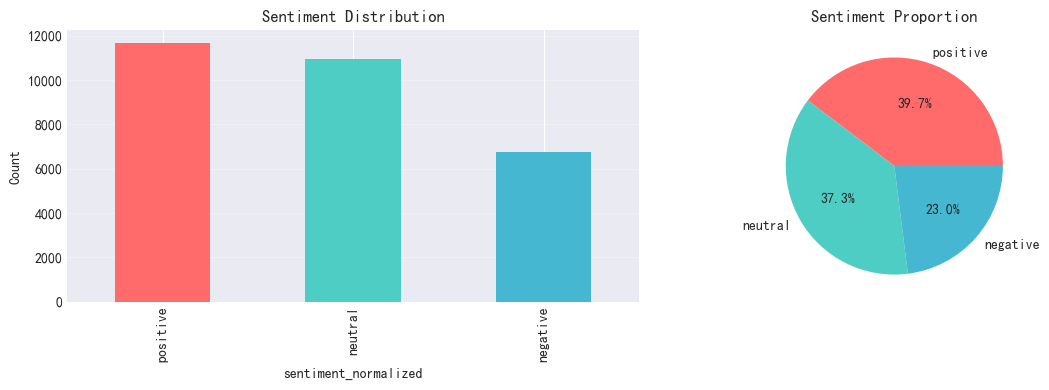

In [34]:
# Analyze sentiment distribution
sentiment_counts = df['sentiment_normalized'].value_counts()
print("Sentiment distribution:")
print(sentiment_counts)
print(f"\nPercentage:")
print((sentiment_counts / len(df) * 100).round(1))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sentiment_counts.plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_title('Sentiment Distribution', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

(sentiment_counts / len(df) * 100).plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                         colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_title('Sentiment Proportion', fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [35]:
# Define balancing function (for future use)
from sklearn.utils import resample

def balance_dataset(df, target_col, method='oversample'):
    """Balance dataset using oversampling or undersampling"""
    if method == 'oversample':
        max_count = df[target_col].value_counts().max()
        balanced_dfs = []
        for class_label in df[target_col].unique():
            class_df = df[df[target_col] == class_label]
            if len(class_df) < max_count:
                class_df_resampled = resample(class_df, n_samples=max_count, random_state=42)
            else:
                class_df_resampled = class_df
            balanced_dfs.append(class_df_resampled)
        return pd.concat(balanced_dfs, ignore_index=True)
    
    elif method == 'undersample':
        min_count = df[target_col].value_counts().min()
        balanced_dfs = []
        for class_label in df[target_col].unique():
            class_df = df[df[target_col] == class_label]
            class_df_resampled = resample(class_df, n_samples=min_count, random_state=42)
            balanced_dfs.append(class_df_resampled)
        return pd.concat(balanced_dfs, ignore_index=True)

print("✓ Balance function defined (will apply during training)")

✓ Balance function defined (will apply during training)


## 4. Split Dataset

In [36]:
# Split into train/validation/test (80:10:10)
train_df, temp_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['sentiment_normalized']
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['sentiment_normalized']
)

print(f"Dataset split (80:10:10):")
print(f"  Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Val:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Dataset split (80:10:10):
  Train: 23500 (80.0%)
  Val:   2937 (10.0%)
  Test:  2938 (10.0%)


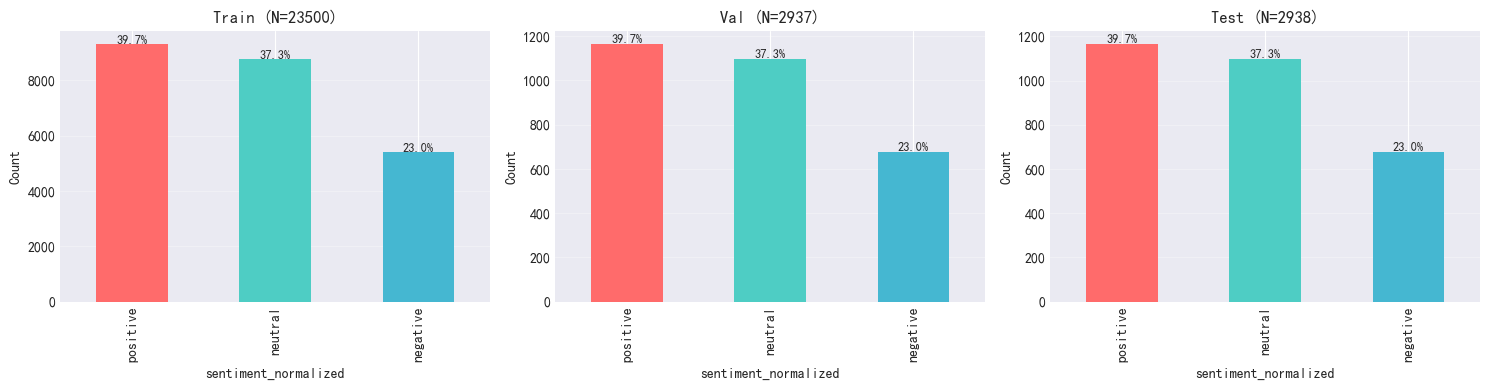

✓ Dataset splits verified


In [37]:
# Verify sentiment distribution across splits
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, dataset) in enumerate([('Train', train_df), ('Val', val_df), ('Test', test_df)]):
    sentiment_dist = dataset['sentiment_normalized'].value_counts()
    sentiment_dist.plot(kind='bar', ax=axes[idx], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[idx].set_title(f'{name} (N={len(dataset)})', fontweight='bold')
    axes[idx].set_ylabel('Count')
    axes[idx].grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(sentiment_dist.values):
        pct = v / len(dataset) * 100
        axes[idx].text(i, v + 5, f'{pct:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()
print("✓ Dataset splits verified")

## 5. Feature Engineering

In [38]:
# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    lowercase=True
)

X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['text_cleaned'])
X_val_tfidf = tfidf_vectorizer.transform(val_df['text_cleaned'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['text_cleaned'])

print(f"✓ TF-IDF vectorization completed")
print(f"  Features: {X_train_tfidf.shape[1]}")
print(f"  Train: {X_train_tfidf.shape}")
print(f"  Val:   {X_val_tfidf.shape}")
print(f"  Test:  {X_test_tfidf.shape}")

# Save vectorizer
import joblib
joblib.dump(tfidf_vectorizer, '../models/tfidf_vectorizer.pkl')
print(f"✓ Vectorizer saved")

✓ TF-IDF vectorization completed
  Features: 5000
  Train: (23500, 5000)
  Val:   (2937, 5000)
  Test:  (2938, 5000)
✓ Vectorizer saved


In [39]:
# Inspect TF-IDF features
feature_names = tfidf_vectorizer.get_feature_names_out()

# Find most important features
tfidf_array = X_train_tfidf.toarray()
mean_tfidf = tfidf_array.mean(axis=0)
top_indices = np.argsort(mean_tfidf)[-20:][::-1]

print(f"Top 20 features by mean TF-IDF:")
for idx in top_indices:
    print(f"  {feature_names[idx]}: {mean_tfidf[idx]:.4f}")

Top 20 features by mean TF-IDF:
  增长: 0.0241
  同比: 0.0195
  亿元: 0.0184
  公司: 0.0164
  stock: 0.0152
  同比 增长: 0.0128
  股份: 0.0109
  百分点: 0.0107
  下降: 0.0102
  指数: 0.0101
  投资: 0.0095
  上涨: 0.0088
  亿元 同比: 0.0087
  美元: 0.0086
  月份: 0.0078
  科技: 0.0078
  market: 0.0076
  中国: 0.0075
  10: 0.0073
  分别: 0.0072


In [40]:
# Label encoding
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(train_df['sentiment_normalized'])
y_val = label_encoder.transform(val_df['sentiment_normalized'])
y_test = label_encoder.transform(test_df['sentiment_normalized'])

# Save label encoder
joblib.dump(label_encoder, '../models/label_encoder.pkl')

print(f"✓ Label encoding completed")
print(f"  Mapping: {dict(enumerate(label_encoder.classes_))}")

✓ Label encoding completed
  Mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}


## 6. Save Processed Data

In [41]:
# Save processed datasets
train_df.to_csv('../data/train_test/train.csv', index=False)
val_df.to_csv('../data/train_test/validation.csv', index=False)
test_df.to_csv('../data/train_test/test.csv', index=False)

# Save feature matrices
import scipy.sparse as sp
sp.save_npz('../data/train_test/X_train_tfidf.npz', X_train_tfidf)
sp.save_npz('../data/train_test/X_val_tfidf.npz', X_val_tfidf)
sp.save_npz('../data/train_test/X_test_tfidf.npz', X_test_tfidf)

# Save labels
np.save('../data/train_test/y_train.npy', y_train)
np.save('../data/train_test/y_val.npy', y_val)
np.save('../data/train_test/y_test.npy', y_test)

print("✓ All processed data saved to data/train_test/")

✓ All processed data saved to data/train_test/


In [42]:
# Data preprocessing summary
print(f"""
{'='*60}
Data Preprocessing Summary
{'='*60}

Dataset Split:
  Training:   {len(train_df):>6} samples ({len(train_df)/len(df)*100:.1f}%)
  Validation: {len(val_df):>6} samples ({len(val_df)/len(df)*100:.1f}%)
  Test:       {len(test_df):>6} samples ({len(test_df)/len(df)*100:.1f}%)

Class Distribution (Training):
  {dict(zip(label_encoder.classes_, [f"{c} ({c/len(y_train)*100:.1f}%)" for c in np.bincount(y_train)]))}

Feature Dimensions: {X_train_tfidf.shape[1]}

✓ All processed data and model files saved successfully
""")


Data Preprocessing Summary

Dataset Split:
  Training:    23500 samples (80.0%)
  Validation:   2937 samples (10.0%)
  Test:         2938 samples (10.0%)

Class Distribution (Training):
  {'negative': '5407 (23.0%)', 'neutral': '8771 (37.3%)', 'positive': '9322 (39.7%)'}

Feature Dimensions: 5000

✓ All processed data and model files saved successfully

